# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [87]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 12

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


## 1. Initialization

In [88]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## 2. Data Prep

In [89]:
X_np = X_full.numpy()
y_np = y_full.numpy()

In [90]:
# Split Data: 70% Training, 30% Validation
X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(
    X_np, y_np, test_size=0.3, random_state=GROUP_NUMBER, stratify=y_np
)

In [107]:
X_train = torch.tensor(X_train_raw, dtype=torch.float32)
y_train = torch.tensor(y_train_raw, dtype=torch.float32)
X_val = torch.tensor(X_val_raw, dtype=torch.float32)
y_val = torch.tensor(y_val_raw, dtype=torch.float32)

In [92]:
print(f"Training Set: {X_train.shape[0]} samples")
print(f"Validation Set: {X_val.shape[0]} samples")

Training Set: 2100 samples
Validation Set: 900 samples


## 3. ARCHITECT THE FILTER

In [106]:
input_dim = 2
hidden_dim = 16
output_dim = 1

In [105]:
def init_params(n_in, n_out):
    # Standard Normal * sqrt(2/n_in)
    weights = torch.randn(n_in, n_out) * np.sqrt(2. / n_in)
    bias = torch.zeros(1, n_out)

    weights.requires_grad_(True)
    bias.requires_grad_(True)
    return weights, bias

In [95]:
# Initialize Layers
W1, b1 = init_params(input_dim, hidden_dim)
W2, b2 = init_params(hidden_dim, hidden_dim)
W3, b3 = init_params(hidden_dim, hidden_dim)
W4, b4 = init_params(hidden_dim, output_dim)

# Groupin up parameters
parameters = [W1, b1, W2, b2, W3, b3, W4, b4]

## 4. Training Functions

In [96]:
def forward(x):
    # Layer 1
    z1 = torch.matmul(x, W1) + b1
    a1 = torch.relu(z1)

    # Layer 2
    z2 = torch.matmul(a1, W2) + b2
    a2 = torch.relu(z2)

    # Layer 3
    z3 = torch.matmul(a2, W3) + b3
    a3 = torch.relu(z3)

    # Layer 4 (Output)
    z4 = torch.matmul(a3, W4) + b4
    y_pred = torch.sigmoid(z4)

    return y_pred

def compute_loss(y_pred, y_true):
    epsilon = 1e-7
    y_pred = torch.clamp(y_pred, epsilon, 1 - epsilon)

    # Formula: -1/N * sum(y*log(p) + (1-y)*log(1-p))
    loss = -torch.mean(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
    return loss

def compute_accuracy(y_pred, y_true):
    # Threshold at 0.5
    predictions = (y_pred >= 0.5).float()
    correct = (predictions == y_true).float().sum()
    return correct / y_true.shape[0]

## 5. TRAINING LOOP (Stochastic Gradient Descent)

In [97]:
epochs = 5000
learning_rate = 0.04

In [98]:
history = {'train_loss': [], 'val_loss': [],'train_acc': [], 'val_acc': [], 'epochs': []}

In [99]:
for epoch in range(epochs):
    # Forward Pass
    y_pred_train = forward(X_train)
    loss = compute_loss(y_pred_train, y_train)

    # Backward Pass (Autograd)
    loss.backward()

    # Manual Gradient Descent
    with torch.no_grad():
        for param in parameters:
            # w_new = w_old - lr * gradient
            param -= learning_rate * param.grad

            # Reset gradients to zero for next iteration
            param.grad.zero_()

    # Validation Check
    if epoch % 10 == 0:
        with torch.no_grad():
            y_pred_val = forward(X_val)
            val_loss = compute_loss(y_pred_val, y_val)

            train_acc = compute_accuracy(y_pred_train, y_train)
            val_acc = compute_accuracy(y_pred_val, y_val)

        history['train_loss'].append(loss.item())
        history['val_loss'].append(val_loss.item())
        history['train_acc'].append(train_acc.item())
        history['val_acc'].append(val_acc.item())
        history['epochs'].append(epoch)

    if epoch % 500 == 0:
        print(f"Epoch {epoch:04d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f} | Val Acc: {val_acc:.4f}")

Epoch 0000 | Train Loss: 1.4670 | Val Loss: 1.0575 | Val Acc: 0.5644
Epoch 0500 | Train Loss: 0.6111 | Val Loss: 0.6104 | Val Acc: 0.5678
Epoch 1000 | Train Loss: 0.5965 | Val Loss: 0.5958 | Val Acc: 0.6278
Epoch 1500 | Train Loss: 0.5607 | Val Loss: 0.5589 | Val Acc: 0.6967
Epoch 2000 | Train Loss: 0.4675 | Val Loss: 0.4736 | Val Acc: 0.7822
Epoch 2500 | Train Loss: 0.3879 | Val Loss: 0.4025 | Val Acc: 0.8778
Epoch 3000 | Train Loss: 0.3413 | Val Loss: 0.3622 | Val Acc: 0.9111
Epoch 3500 | Train Loss: 0.3194 | Val Loss: 0.3478 | Val Acc: 0.9111
Epoch 4000 | Train Loss: 0.3087 | Val Loss: 0.3424 | Val Acc: 0.9189
Epoch 4500 | Train Loss: 0.3041 | Val Loss: 0.3415 | Val Acc: 0.9178


## 6. Visualization

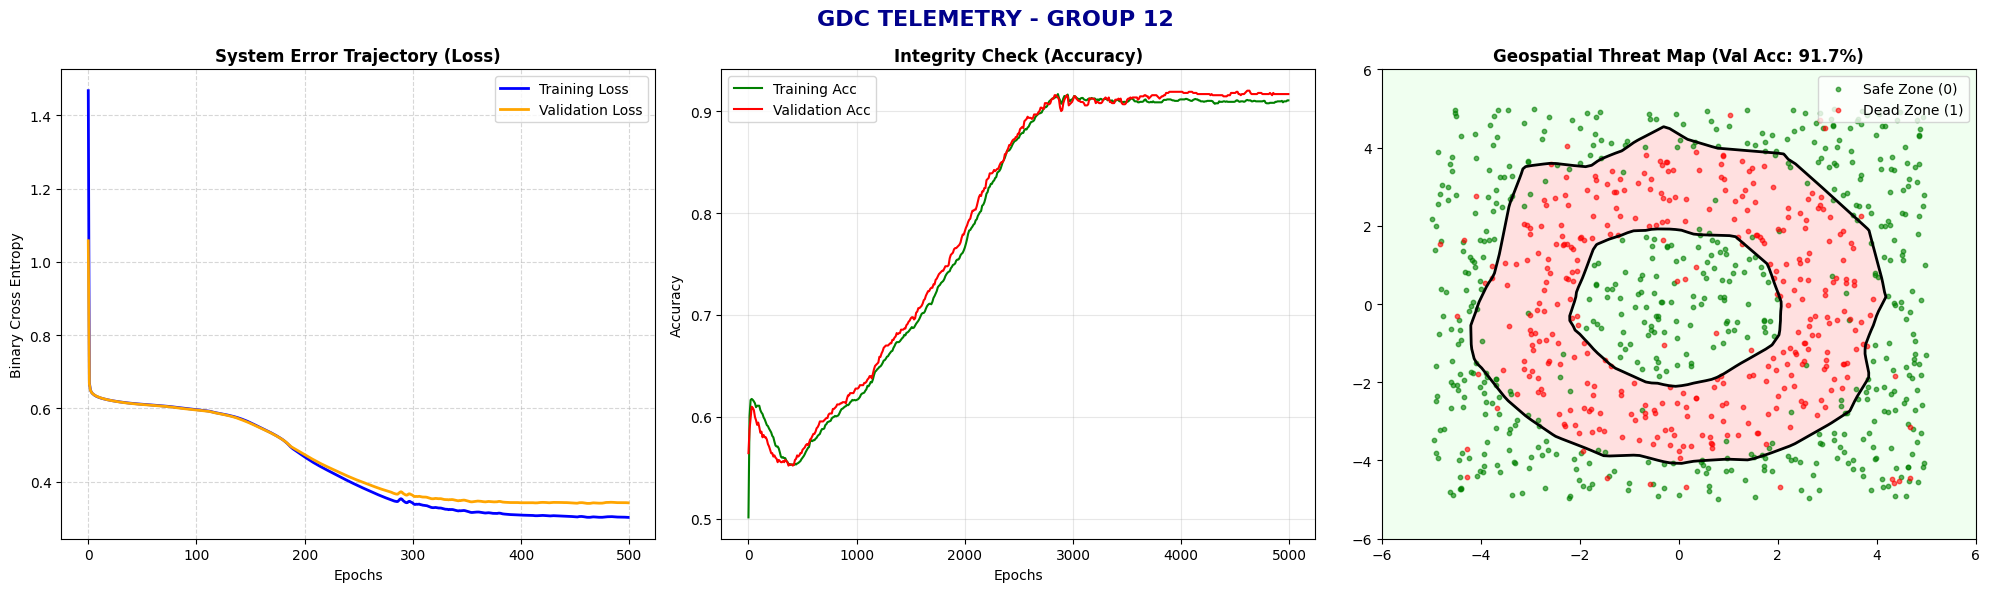

In [100]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
plt.suptitle(f"GDC DashBoard - GROUP {GROUP_NUMBER}", fontsize=16, fontweight='bold', color='darkblue')

# Panel 1: System Error Trajectory (Loss)
axes[0].plot(history['train_loss'], label='Training Loss', color='blue', linewidth=2)
axes[0].plot(history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
axes[0].set_title("System Error Trajectory (Loss)", fontweight='bold')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Binary Cross Entropy")
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].legend()

# Panel 2: Integrity Check (Accuracy)
axes[1].plot(history['epochs'], history['train_acc'], label='Training Acc', color='green', linewidth=1.5)
axes[1].plot(history['epochs'], history['val_acc'], label='Validation Acc', color='red', linewidth=1.5)
axes[1].set_title("Integrity Check (Accuracy)", fontweight='bold')
axes[1].set_ylabel("Accuracy")
axes[1].set_xlabel("Epochs")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# Panel 3: Geospatial Threat Map (Decision Boundary)
x_min, x_max = -6, 6
y_min, y_max = -6, 6
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

with torch.no_grad():
    Z = forward(grid_points).reshape(xx.shape)

# Contours
axes[2].contourf(xx, yy, Z, levels=[0, 0.5, 1], colors=['#e6ffe6', '#ffcccc'], alpha=0.6)
# Boundary
axes[2].contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)

# Overlaying Validation Data
safe_idx = (y_val.view(-1) == 0)
dead_idx = (y_val.view(-1) == 1)
axes[2].scatter(X_val[safe_idx, 0], X_val[safe_idx, 1], c='green', s=10, label='Safe Zone (0)', alpha=0.6)
axes[2].scatter(X_val[dead_idx, 0], X_val[dead_idx, 1], c='red', s=10, label='Dead Zone (1)', alpha=0.6)

axes[2].set_title(f"Geospatial Threat Map (Val Acc: {history['val_acc'][-1]*100:.1f}%)", fontweight='bold')
axes[2].legend(loc='upper right')
axes[2].set_xlim(-6, 6)
axes[2].set_ylim(-6, 6)

plt.tight_layout()
plt.show()